# Project 1: Classification Analysis on Textual Data

**Authors**
* Zhiyuan Chen, chen0error@g.ucla.edu, 605363281
* Ranjana Vittal, ranjanavittal@g.ucla.edu, 605629219
* Krish Kabra, krish97@g.ucla.edu, 404593821 

In [1]:
import sys
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import pandas as pd
import random
random.seed(42)
import nltk, string

!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

runningOnColab = 'google.colab' in sys.modules
if runningOnColab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  # Please link EE 219 folder to your personal drive directory under the following path
  %cd '/content/drive/My Drive/Colab Notebooks/EE 219/Project 1' 
  %ls
  nltk.download('all')
  !pip freeze > requirements.txt

Requirement already up-to-date: ipykernel in /usr/local/lib/python3.6/dist-packages (5.4.3)
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/13z517vur60HDVoYIHkYanSKA_W-dmNBG/EE 219/Project 1
 figures/   glove.6B.zip      'Project_1 (Jupyter).ipynb'
 glove/    'Project 1.ipynb'  'Project 1 Report.gdoc'
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package br

## Getting familiar with the dataset 

In [ ]:
from sklearn.datasets import fetch_20newsgroups

### Question 1: Visualizing the dataset
Plot a histogram of the number of training documents for each of the 20 categories to check if they are evenly distributed.

In [ ]:
twenty_train = fetch_20newsgroups(subset='train', 
                                  categories=None, 
                                  shuffle=True,
                                  random_state=42, 
                                 )

In [ ]:
all_categories=twenty_train.target_names
num_in_categories=[]

for category in all_categories:
  temp_train = fetch_20newsgroups(subset='train', 
                                  categories=[category], 
                                  shuffle=True,
                                  random_state=42, 
                                 )
  num_in_categories.append(len(temp_train.data))  

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

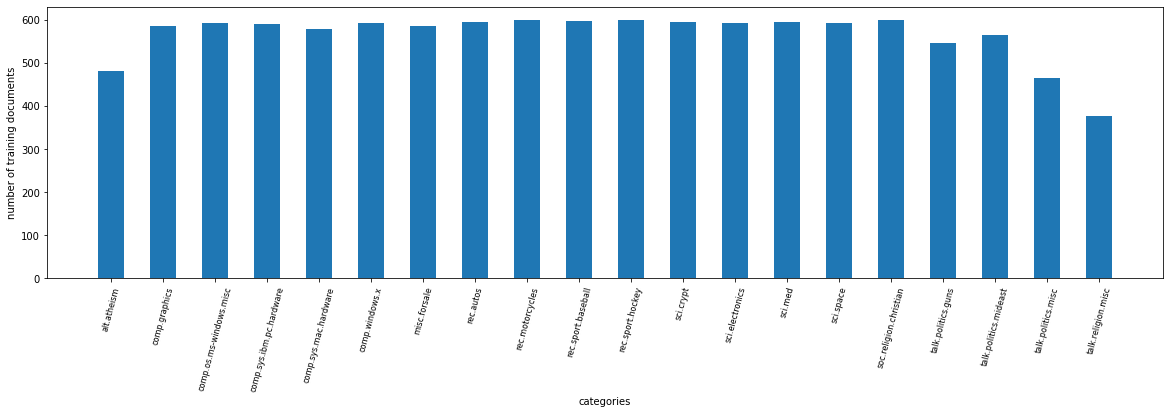

In [ ]:
import matplotlib.pyplot as plt

x=all_categories
y=num_in_categories

plt.figure(figsize=(20, 5))
plt.bar(x,y,width=0.5)
plt.xlabel('categories')
plt.ylabel('number of training documents')
plt.xticks(rotation = (75), fontsize = 8, va='top', ha='center') 

## Binary Classification

### Question 2: Feature extraction

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer

def pennmorphy(penntag):
    morphytag = {'NN':'n', 'JJ':'a','VB':'v', 'RB':'r'}
    try:
        return morphytag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(text):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(word.lower(), pos=pennmorphy(tag)) for word, tag in pos_tag(nltk.word_tokenize(text))]

def lemmatize_dataset(dataset):
  for n,lemsent in enumerate(dataset.data):
    lemsent = lemmatize_sent(lemsent) # lemmatize
    lemsent = [i for i in lemsent if i not in string.punctuation] # remove punctuation
    lemsent = [i for i in lemsent if not i.isdigit()] # remove numbers
    dataset.data[n] = " ".join(lemsent)  
  return dataset

categories = ['comp.graphics', 'comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware','rec.autos', 'rec.motorcycles','rec.sport.baseball', 'rec.sport.hockey']

traindataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42)# getting training data
traindataset = lemmatize_dataset(traindataset)

testdataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42) # getting test data
testdataset = lemmatize_dataset(testdataset)

tfi_vect = TfidfVectorizer(stop_words='english',min_df=3)

XTrain_tfi = tfi_vect.fit_transform(traindataset.data) # making the tfidf train matrix
print("Shape of TF-IDF train matrix: ", XTrain_tfi.shape)

XTest_tfi = tfi_vect.transform(testdataset.data) # transforming the test data into the tfidf test matrix
print("Shape of TF-IDF test matrix: ", XTest_tfi.shape)

Shape of TF-IDF train matrix:  (4732, 17671)
Shape of TF-IDF test matrix:  (3150, 17671)


### Question 3: Dimensionality reduction

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import NMF

lsi = TruncatedSVD(n_components=50, random_state=42)
XTrain_lsi = lsi.fit_transform(XTrain_tfi) # performing LSI on the tfidf train matrix
XTest_lsi = lsi.transform(XTest_tfi) # performing LSI on the tfidf test matrix
U,Sigm,VT = randomized_svd(XTrain_tfi,n_components=50,random_state=42) # obtaining the left singular matrix, singular values and right singular matrix
Sigm = np.diag(Sigm)
print("Error for LSI: ", np.sum(np.array(XTrain_tfi - U.dot(Sigm).dot(VT))**2))


nmf = NMF(n_components=50, init='random', random_state=42)
XTrain_nmf = nmf.fit_transform(XTrain_tfi) # performing NMF on the tfidf train matrix
XTest_nmf = nmf.transform(XTest_tfi) # performing NMF on the tfidf test matrix
H = nmf.components_
print("Error for NMF: ", np.sum(np.array(XTrain_tfi - XTrain_nmf.dot(H))**2))

Error for LSI:  4116.55988709079
Error for NMF:  4154.185519146454


### Question 4: Support Vector Machines

In [ ]:
# Classification metrics tools 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
import itertools

def plotconfusion_matrix(confm, classes, normalize=False, title='Confusion matrix', cmap_name='Blues'):
    if normalize:
        confm = confm.astype('float') / confm.sum(axis=1)[:, np.newaxis]
    plt.imshow(confm, interpolation='nearest', cmap=plt.get_cmap(cmap_name))
    plt.title(title)
    plt.colorbar()
    tickmarks = np.arange(len(classes))
    plt.xticks(tickmarks, classes, rotation=65)
    plt.yticks(tickmarks, classes)
    scl = '.2f' if normalize else 'd'
    thresh = confm.max() / 2.
    for i, j in itertools.product(range(confm.shape[0]), range(confm.shape[1])):
        plt.text(j, i, format(confm[i, j], scl),horizontalalignment="center",color="white" if confm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def classifier_metrics(ytest,ypred,name="",average='binary'):
    print("Accuracy score for %s: %f" %(name,accuracy_score(ytest,ypred)))
    print("Recall score for %s: %f" % (name,recall_score(ytest,ypred,average=average)))
    print("Precision score for %s: %f" % (name,precision_score(ytest,ypred,average=average)))
    print("F-1 score for %s: %f" % (name,f1_score(ytest,ypred,average=average)))

def plotroc_curve(ytest,decision_function,name=""):
    falsepr = dict()
    truepr = dict()
    rocauc = dict()
    falsepr, truepr, thresholds = roc_curve(ytest, decision_function)
    rocauc = auc(falsepr, truepr)
    plt.figure()
    lw = 2
    plt.plot(falsepr, truepr, color='darkorange',lw=lw, label='ROC curve (area = %0.4f)' % rocauc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate');
    plt.title('%s ROC curve' % name);plt.legend(loc="lower right")



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy score for Hard Margin SVM: 0.971429
Recall score for Hard Margin SVM: 0.976730
Precision score for Hard Margin SVM: 0.966999
F-1 score for Hard Margin SVM: 0.971840
Accuracy score for Soft Margin SVM: 0.667302
Recall score for Soft Margin SVM: 1.000000
Precision score for Soft Margin SVM: 0.602729
F-1 score for Soft Margin SVM: 0.752129


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Grid search results for SVM:  {'mean_fit_time': array([0.01311278, 0.01691399, 0.01861591, 0.02713838, 0.07004118,
       0.3805501 , 0.89352155]), 'std_fit_time': array([0.00172985, 0.00065973, 0.00013378, 0.00153199, 0.00201607,
       0.07225105, 0.01751204]), 'mean_score_time': array([0.00148716, 0.00136466, 0.00136156, 0.00135827, 0.00135837,
       0.00181961, 0.00273194]), 'std_score_time': array([2.22986696e-04, 1.79878246e-05, 1.11271767e-05, 1.01924988e-05,
       8.91902204e-06, 3.62044496e-04, 1.53728123e-03]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.94825766, 0.97148891, 0.97571278, 0.97465681, 0.97782471,
       0.97676874, 0.97571278]), 'split1_test_score': array([0.93664203, 0.96726505, 0.97360084, 0.9

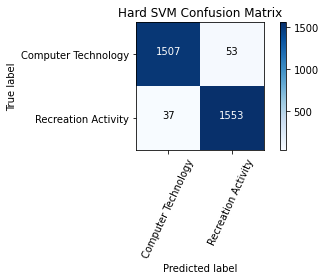

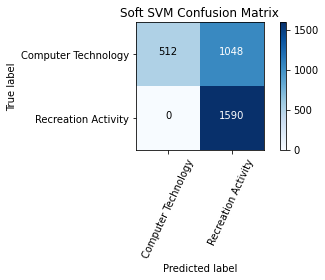

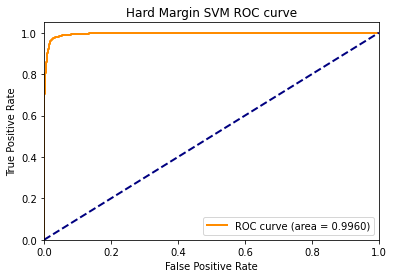

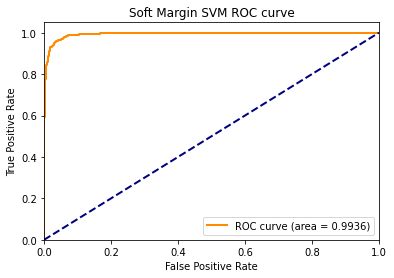

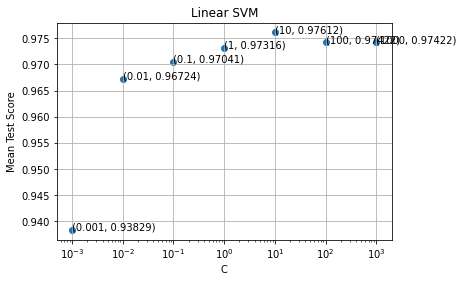

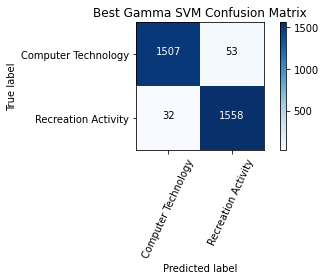

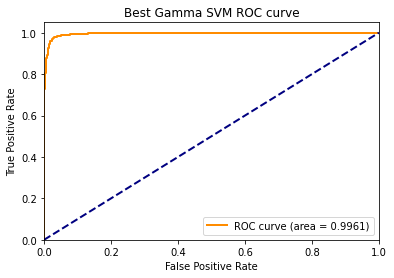

In [ ]:
# SVM 
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

hardSVM = LinearSVC(C=1000,random_state=42,max_iter=10000)
softSVM = LinearSVC(C=0.0001,random_state=42,max_iter=10000)

ytrain = [int(i/4) for i in traindataset.target] # making the train labels compatible for binary classification
ytest = [int(i/4) for i in testdataset.target] # making the test labels compatible for binary classification

ypred_hard = hardSVM.fit(XTrain_lsi,ytrain).predict(XTest_lsi) # predicting labels for hard margin SVM
ypred_soft = softSVM.fit(XTrain_lsi,ytrain).predict(XTest_lsi) # predicting labels for soft margin SVM

classifier_metrics(ytest,ypred_hard,name="Hard Margin SVM")
classifier_metrics(ytest,ypred_soft,name="Soft Margin SVM")

classnames = ['Computer Technology', 'Recreation Activity']
hard_confm = confusion_matrix(ytest,ypred_hard) # Hard SVM Confusion matrix
plt.figure()
plotconfusion_matrix(hard_confm, classes=classnames, title='Hard SVM Confusion Matrix') 
soft_confm = confusion_matrix(ytest,ypred_soft) # Soft SVM Confusion matrix
plt.figure()
plotconfusion_matrix(soft_confm, classes=classnames, title='Soft SVM Confusion Matrix')

plotroc_curve(ytest,hardSVM.decision_function(XTest_lsi),name="Hard Margin SVM") # Hard SVM ROC curve 
plotroc_curve(ytest,softSVM.decision_function(XTest_lsi),name="Soft Margin SVM") # Soft SVM ROC curve 

lsvc = LinearSVC(random_state=42,max_iter=10000) 
params = {'C':[0.001,0.01,0.1,1,10,100,1000]}
crof = GridSearchCV(lsvc,params,cv=5,scoring='accuracy') # Finding the best gamma using cross validation
crof.fit(XTrain_lsi,ytrain)

x = [0.001,0.01,0.1,1,10,100,1000]
y = crof.cv_results_['mean_test_score']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):                                       
    ax.annotate('(%s, %.5f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title("Linear SVM")
plt.grid()
ax.set_xscale('log')

ypred_cv = crof.best_estimator_.predict(XTest_lsi)
bestsvm_gamma = crof.best_estimator_.C

print("Grid search results for SVM: ", crof.cv_results_)
print("Best estimator for SVM: ", crof.best_estimator_)
print("Best parameters for SVM: ", crof.best_params_)
print("Best score for SVM: ", crof.best_score_)
print("Best Gamma for SVM: ", bestsvm_gamma)
classifier_metrics(ytest,ypred_cv,name="Best Gamma SVM")

cv_confm = confusion_matrix(ytest,ypred_cv) # Best Gamma SVM confusion matrix
plt.figure()
plotconfusion_matrix(cv_confm, classes=classnames, title='Best Gamma SVM Confusion Matrix')

plotroc_curve(ytest,crof.best_estimator_.decision_function(XTest_lsi),name="Best Gamma SVM") # Best Gamma SVM ROC curve 

### Question 5: Logistic classification

Coefficients learned by logistic regression without regularization:  [[ -4.55440677 125.1605917  -20.35767296  94.99196443  11.37674591
  -22.82412538   1.9086466   -0.69732592  27.48163267   7.0162825
   34.27838325  -7.17599071 -13.04919293  11.54206628   4.42237215
  -13.39201477 -10.11482407   9.98945064  16.993775   -13.25015443
    6.73779118   6.03845415 -10.38875915   2.82484514 -17.48921503
    7.7622834   -2.35742832  -0.8632784   25.05020188   0.19334077
   -0.21915204  14.21686376  12.19866494   0.15249264   9.10065483
   -1.14853355   3.04186636 -14.11113173   5.09854391   4.83504711
   10.27718084  18.19433368   5.10444983   3.88027023   7.8106733
    7.26534772   1.4532852   -3.96477002 -10.48921906 -11.12249341]]
Accuracy score for Logistic Regression without regularization: 0.971111
Recall score for Logistic Regression without regularization: 0.976101
Precision score for Logistic Regression without regularization: 0.966978
F-1 score for Logistic Regression without regu

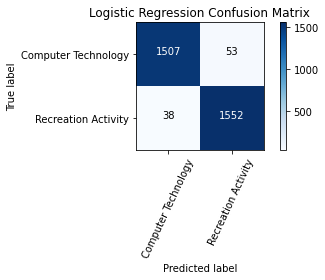

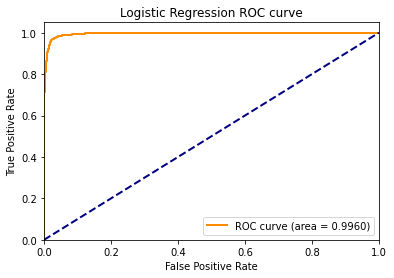

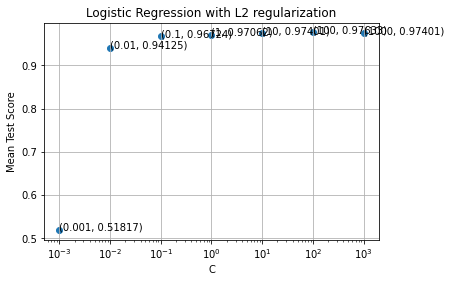

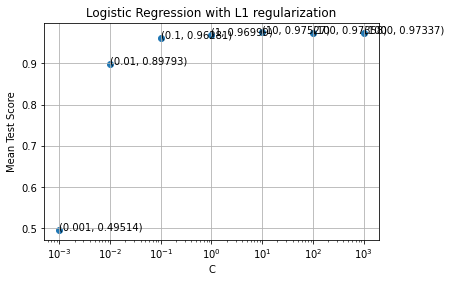

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=10**10,random_state=42,max_iter=10000) # Logistic regression without regularization
ypred_logreg = logreg.fit(XTrain_lsi,ytrain).predict(XTest_lsi)
print("Coefficients learned by logistic regression without regularization: ", logreg.coef_)
classifier_metrics(ytest,ypred_logreg,name="Logistic Regression without regularization")
logreg_confm = confusion_matrix(ytest,ypred_logreg) # logistic regression without regularization confusion matrix
plt.figure()
plotconfusion_matrix(logreg_confm, classes=classnames, title='Logistic Regression Confusion Matrix')
plotroc_curve(ytest,logreg.decision_function(XTest_lsi),name="Logistic Regression") # logistic regression without regularization roc curve

logreg_L2 = LogisticRegression(random_state=42,max_iter=10000) # logistic regression with L2 regularization
clasf_L2 = GridSearchCV(logreg_L2,params,cv=5,scoring='accuracy') # grid search for best gamma for L2 regularization
ypred_L2 = clasf_L2.fit(XTrain_lsi,ytrain).best_estimator_.predict(XTest_lsi)
bestL2_gamma = clasf_L2.best_estimator_.C

x = [0.001,0.01,0.1,1,10,100,1000]
y = clasf_L2.cv_results_['mean_test_score']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):                                       
    ax.annotate('(%s, %.5f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title("Logistic Regression with L2 regularization")
plt.grid()
ax.set_xscale('log')

print("Grid search results for logistic regression with L-2 regularization: ", clasf_L2.cv_results_)
print("Best estimator for logistic regression with L-2 regularization: ", clasf_L2.best_estimator_)
print("Best parameters for logistic regression with L-2 regularization: ", clasf_L2.best_params_)
print("Best score for logistic regression with L-2 regularization: ", clasf_L2.best_score_)
print("Best Gamma for logistic regression with L-2 regularization: ", bestL2_gamma)
print("Coefficients learned by logistic regression with L-2 regularization: ", clasf_L2.best_estimator_.coef_)
classifier_metrics(ytest,ypred_L2,name="Logistic Regression with L-2 regularization")

logreg_L1 = LogisticRegression(penalty='l1',solver='liblinear',random_state=42,max_iter=10000) # logistic regression with L1 regularization
clasf_L1 = GridSearchCV(logreg_L1,params,cv=5,scoring='accuracy') # grid search for best gamma for L1 regularization
ypred_L1 = clasf_L1.fit(XTrain_lsi,ytrain).best_estimator_.predict(XTest_lsi)
bestL1_gamma = clasf_L1.best_estimator_.C

x = [0.001,0.01,0.1,1,10,100,1000]
y = clasf_L1.cv_results_['mean_test_score']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):                                       
    ax.annotate('(%s, %.5f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title("Logistic Regression with L1 regularization")
plt.grid()
ax.set_xscale('log')

print("Grid search results for logistic regression with L-1 regularization: ", clasf_L1.cv_results_)
print("Best estimator for logistic regression with L-1 regularization: ", clasf_L1.best_estimator_)
print("Best parameters for logistic regression with L-1 regularization: ", clasf_L1.best_params_)
print("Best score for logistic regression with L-1 regularization: ", clasf_L1.best_score_)
print("Best Gamma for logistic regression with L-1 regularization: ", bestL1_gamma)
print("Coefficients learned by logistic regression with L-1 regularization: ", clasf_L1.best_estimator_.coef_)
classifier_metrics(ytest,ypred_L1,name="Logistic Regression with L-1 regularization")


### Question 6: Naive Bayes classification

Accuracy score for Gaussian Naive Bayes: 0.894921
Recall score for Gaussian Naive Bayes: 0.972956
Precision score for Gaussian Naive Bayes: 0.843052
F-1 score for Gaussian Naive Bayes: 0.903358


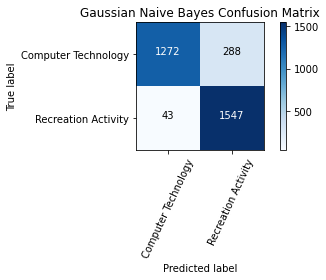

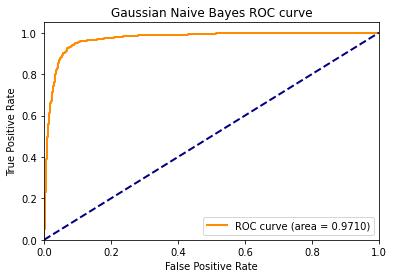

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
ypred_nb = clf.fit(XTrain_lsi, ytrain).predict(XTest_lsi)
classifier_metrics(ytest,ypred_nb,name="Gaussian Naive Bayes")
nb_confm = confusion_matrix(ytest,ypred_nb)
plt.figure()
plotconfusion_matrix(nb_confm, classes=classnames, title='Gaussian Naive Bayes Confusion Matrix')
plotroc_curve(ytest,clf.predict_proba(XTest_lsi)[:,1],name="Gaussian Naive Bayes")

### Question 7: Grid search of parameters

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import Memory
from tempfile import mkdtemp
from shutil import rmtree


def with_lem(dat):
    lemsent = lemmatize_sent(dat) # lemmatize
    lemsent = [i for i in lemsent if i not in string.punctuation] # remove punctuation
    lemsent = [i for i in lemsent if not i.isdigit()] # remove numbers
    return lemsent

def no_lem(dat):
    lemsent = nltk.word_tokenize(dat)
    lemsent = [i for i in lemsent if i not in string.punctuation] # remove punctuation
    lemsent = [i for i in lemsent if not i.isdigit()] # remove numbers
    return lemsent

data_with_headfoot = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42) # keeping headers and footer
data_no_headfoot = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42, remove=('headers','footers')) # removing headers and footers

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipe0 = Pipeline([('vect',TfidfVectorizer(stop_words='english')),
                     ('reduce_dim',None),
                     ('classify',None)], memory=memory)
                     
param_grid = {
    'vect__min_df': (3,5),
    'vect__analyzer': (with_lem, no_lem),
    'reduce_dim':(TruncatedSVD(n_components=50,random_state=42), NMF(n_components=50,init='random', random_state=42)),
    'classify':(LinearSVC(C=bestsvm_gamma,random_state=42), LogisticRegression(penalty='l2',C=bestL2_gamma,random_state=42),LogisticRegression(penalty='l1',solver='liblinear',C=bestL1_gamma,random_state=42), GaussianNB())
    } # parameter grid for the pipeline to find the best combination

gr = GridSearchCV(pipe0,cv=5,param_grid=param_grid,scoring='accuracy')

gr.fit(data_with_headfoot.data, data_with_headfoot.target)
print("Best score for pipeline with headers and footers: ", gr.best_score_)
print("Best params for pipeline with headers and footers: ", gr.best_params_)
print("Best estimator for pipeline with headers and footers: ", gr.best_estimator_)

gr.fit(data_no_headfoot.data, data_with_headfoot.target)
rmtree(cachedir)
print("Best score for pipeline without headers and footers: ", gr.best_score_)
print("Best params for pipeline without headers and footers: ", gr.best_params_)
print("Best estimator for pipeline without headers and footers: ", gr.best_estimator_)


ypred_pipe1 = LinearSVC(C=10,random_state=42).fit(XTrain_lsi,ytrain).predict(XTest_lsi) # testing the best combination for dataset with headers and footers
classifier_metrics(ytest,ypred_pipe1,name="Pipeline1")

traindataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42, remove=('headers','footers')) # training set with removed headers and footers
for n,lemsent in enumerate(traindataset.data):
    lemsent = lemmatize_sent(lemsent) # lemmatize
    lemsent = [i for i in lemsent if i not in string.punctuation] # remove punctuation
    lemsent = [i for i in lemsent if not i.isdigit()] # remove numbers
    traindataset.data[n] = " ".join(lemsent)

testdataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42, remove=('headers','footers'))  # testing set with removed headers and footers
for n,lemsent in enumerate(testdataset.data):
    lemsent = lemmatize_sent(lemsent) # lemmatize
    lemsent = [i for i in lemsent if i not in string.punctuation] # remove punctuation
    lemsent = [i for i in lemsent if not i.isdigit()] # remove numbers
    testdataset.data[n] = " ".join(lemsent)

tfi_vect = TfidfVectorizer(stop_words='english',min_df=3)

XTrain_tfi = tfi_vect.fit_transform(traindataset.data)
XTest_tfi = tfi_vect.transform(testdataset.data)

lsi = TruncatedSVD(n_components=50, random_state=42)
XTrain_lsi = lsi.fit_transform(XTrain_tfi)
XTest_lsi = lsi.transform(XTest_tfi)

ypred_pipe2 = LogisticRegression(random_state=42,C=10).fit(XTrain_lsi,ytrain).predict(XTest_lsi) # testing best combination for dataset without headers and footers
classifier_metrics(ytest,ypred_pipe2,name="Pipeline2")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/tmp/tmpcwk7cdtl'", use "location='/tmp/tmpcwk7cdtl'" instead.


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
                max_features=None, min_df=3, ngram_range=(1, 1), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words='english',
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None), 
[ 'Subject: Re: Jewish Baseball Players?\n'
  'From: rbd@flash.ece.uc.edu (Bobby Davis)\n'
  'Organization: University of Cincinnati\n'
  'NNTP-Posting-Host: flash.ece.uc.edu\n'
  'Lines: 5\n'
  '\n'
  'Hank Greenberg was probably the greatest ever.  He was also subject to a\n'
  'lot of heckli

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.77s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 76.5s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x16076 sparse matrix of type '<class 'numpy.float64'>'
	with 430920 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 1.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
  

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 74.4s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x15639 sparse matrix of type '<class 'numpy.float64'>'
	with 423497 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 1.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
  

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.76s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 75.9s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x16002 sparse matrix of type '<class 'numpy.float64'>'
	with 429051 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
  

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 76.1s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x15955 sparse matrix of type '<class 'numpy.float64'>'
	with 429030 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 1.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
  

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.77s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 73.9s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x15928 sparse matrix of type '<class 'numpy.float64'>'
	with 429261 stored elements in Compressed Sparse Row format>, 
array([6, ..., 5]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
  

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 76.4s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x9336 sparse matrix of type '<class 'numpy.float64'>'
	with 408311 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
   

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.12s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 74.5s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x9136 sparse matrix of type '<class 'numpy.float64'>'
	with 401608 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
   

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.30s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 76.0s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x9287 sparse matrix of type '<class 'numpy.float64'>'
	with 406450 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
   

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.13s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 75.9s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x9411 sparse matrix of type '<class 'numpy.float64'>'
	with 406897 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
   

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.16s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 73.6s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x9352 sparse matrix of type '<class 'numpy.float64'>'
	with 407137 stored elements in Compressed Sparse Row format>, 
array([6, ..., 5]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
     

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 2.11s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 12.3s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x20645 sparse matrix of type '<class 'numpy.float64'>'
	with 467413 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.95s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 12.4s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x20186 sparse matrix of type '<class 'numpy.float64'>'
	with 458847 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 1.2s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 2.09s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 12.2s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x20599 sparse matrix of type '<class 'numpy.float64'>'
	with 465207 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 2.09s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 12.2s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x20542 sparse matrix of type '<class 'numpy.float64'>'
	with 464737 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 2.12s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 12.1s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x20520 sparse matrix of type '<class 'numpy.float64'>'
	with 465323 stored elements in Compressed Sparse Row format>, 
array([6, ..., 5]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.35s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 12.1s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x12007 sparse matrix of type '<class 'numpy.float64'>'
	with 438361 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.34s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 11.9s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x11721 sparse matrix of type '<class 'numpy.float64'>'
	with 430341 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.48s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 12.1s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x11958 sparse matrix of type '<class 'numpy.float64'>'
	with 436164 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.37s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 12.0s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x12073 sparse matrix of type '<class 'numpy.float64'>'
	with 436114 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.36s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 11.9s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x12017 sparse matrix of type '<class 'numpy.float64'>'
	with 436746 stored elements in Compressed Sparse Row format>, 
array([6, ..., 5]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.8s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7196242c9e038318279dfdbf4fcefbf4
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_o

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/052a27ae866e478e49fe0242a2a037a8
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/0c86613d756c304a9976684cce721fe5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/54262e50da86d0c21148d372f4b44add
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/8da7f3a5548d9860a766295275f0fd4b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/4f5279042c1a26aa2f9a544962e8354c
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/6043338e1bcf74f3e9e7cd2008fdfbac
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/b7515346dd31501bbe563c5b5c02fd64
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/80c4f5c22a30d02676455c378ca8f536
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/a35710794287cfdf2a5c13e17256a052
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/a267fcf65f39c8d0f9555e0331db0ee7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/ade8bc20ca5512666def08a416f0d62c
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/10157edc3fec89b85c1a0387665514a9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/70a886e64cea78f1df3978fdb2a7600e
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/5e6096ffa568d0923ee6aa49c48f4c39
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7a11d5154472a1305b635948000775fe
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/22a9cb13c3b604d5fe37718892dc5883
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/21aa6d04467ebe6ae1c0ed1a65369d09
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7c8d6dd2c7102029891306ac3ebf7874
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7c4c979d4caacb2d0c05692279d0311b
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/5816d32b75a1fb6eb8de63d7c094c222
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/f724d208274fac04ddb0f9c919203531
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/52726cbd942bb58a6007a078b18e0d75
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/118065b7702391591662aad5bc9d030d
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/2b2becedfcc51f11bca5e26d0dee6156
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/cab0d5f88b21e35ce8877192fe645056
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/0f68ed2eb75e340753eb8bb43546dafc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/07ec242933274d09337d9257cccccd9a
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/4fed9aaad488899eead25fd7068d95df
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/9ce89d61d1be3c775f27a44ca6929b31
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/c3b5a601dfa953ac03acc536a84037de
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/fc0a04e83095fc68388ed399910633cb
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/fecfe359cb4003c16d3c68079fa6dd77
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/758220d8f00133f4bfd9e58ef3ac0350
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/9327b36f3c99ad4cf5792fbcebed8f1d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/df6d5211728d1e94ec0724ebef135f0d
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7e0b4b7ec7558d36d70d11203278a297
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/3065417bf38e1d2a1a5485a301f81e0c
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/b581747492c4a250153bfc4dc33d28eb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7196242c9e038318279dfdbf4fcefbf4
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/4b9670559ca909a052d7e20a0a177c30
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/052a27ae866e478e49fe0242a2a037a8
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/0984d80e9142d5c4c25ee2927333080b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/54262e50da86d0c21148d372f4b44add
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/1d19042231db6813875d915012283538
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/4f5279042c1a26aa2f9a544962e8354c
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/542d2a0c84576afe160293cf0b5259e6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/b7515346dd31501bbe563c5b5c02fd64
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/f82bbfb6acff67cb2f3e4e6eb09095a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/a35710794287cfdf2a5c13e17256a052
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/8aefe5878eaec9b3c4cc9f68c6b0bddc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/ade8bc20ca5512666def08a416f0d62c
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/db029f40a70c4607d3b768d9e2bbc10b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/70a886e64cea78f1df3978fdb2a7600e
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/cdd3191a53aaa7f3c3e89f45fc1b9709
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7a11d5154472a1305b635948000775fe
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/6a44fa65a5d35cea36d207cf4a765560
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/21aa6d04467ebe6ae1c0ed1a65369d09
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/8d4fff9761d84fb7c66b1f3e0d75cb04
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7c4c979d4caacb2d0c05692279d0311b
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/85765796b15ba65266bec66c236181b1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/f724d208274fac04ddb0f9c919203531
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/ec69bc86ff7eb86b6baf984c5bea8eb6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/118065b7702391591662aad5bc9d030d
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/b2b4b6e3970334cb917b01d09728a82b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/cab0d5f88b21e35ce8877192fe645056
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/9fac7c705a53475c2688972e3cff5a76
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/07ec242933274d09337d9257cccccd9a
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/f6d157e250146e1bd20840a5c896cb8f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/9ce89d61d1be3c775f27a44ca6929b31
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/05f0367c96696c6f5f1797ed246e957c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/fc0a04e83095fc68388ed399910633cb
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/dd6a66f74da9c8190880abb3ddfa09bc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/758220d8f00133f4bfd9e58ef3ac0350
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/101f4fe5972533305feb83834d55f1c4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/df6d5211728d1e94ec0724ebef135f0d
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/81415ee631b37b2e42712d8b75765f0e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/3065417bf38e1d2a1a5485a301f81e0c
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/c6aa5388dc73a93d48ab782929a17a48
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7196242c9e038318279dfdbf4fcefbf4
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/d7b4e25566b89c4f15cedc6e6839fb1b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/052a27ae866e478e49fe0242a2a037a8
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/0c86613d756c304a9976684cce721fe5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cd

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.88s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 94.3s, 1.6min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<4732x19001 sparse matrix of type '<class 'numpy.float64'>'
	with 542405 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 1.3s, 0.0min
Best score for pipeline with headers and footers:  0.8588336149987386
Best params for pipeline with headers and footers:  {'classify': LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0), 'reduce_dim': Truncate

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.44s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 62.3s, 1.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x12873 sparse matrix of type '<class 'numpy.float64'>'
	with 341921 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
  

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.25s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 60.2s, 1.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x12485 sparse matrix of type '<class 'numpy.float64'>'
	with 335649 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
  

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.47s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 63.0s, 1.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x13030 sparse matrix of type '<class 'numpy.float64'>'
	with 341526 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
  

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.28s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 61.8s, 1.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x12950 sparse matrix of type '<class 'numpy.float64'>'
	with 341239 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
  

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.31s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 59.9s, 1.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x13001 sparse matrix of type '<class 'numpy.float64'>'
	with 341224 stored elements in Compressed Sparse Row format>, 
array([6, ..., 5]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
  

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.08s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 62.0s, 1.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x7380 sparse matrix of type '<class 'numpy.float64'>'
	with 323533 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
   

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 0.90s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 60.1s, 1.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x7192 sparse matrix of type '<class 'numpy.float64'>'
	with 317885 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
   

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 0.92s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 62.7s, 1.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x7410 sparse matrix of type '<class 'numpy.float64'>'
	with 322601 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
   

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 0.91s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 62.0s, 1.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x7438 sparse matrix of type '<class 'numpy.float64'>'
	with 322721 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
   

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.10s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 59.5s, 1.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x7467 sparse matrix of type '<class 'numpy.float64'>'
	with 322665 stored elements in Compressed Sparse Row format>, 
array([6, ..., 5]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
     

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.57s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 9.9s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x16472 sparse matrix of type '<class 'numpy.float64'>'
	with 370598 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.67s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 9.7s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x16049 sparse matrix of type '<class 'numpy.float64'>'
	with 363187 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.59s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 10.0s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x16671 sparse matrix of type '<class 'numpy.float64'>'
	with 369880 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 10.0s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x16553 sparse matrix of type '<class 'numpy.float64'>'
	with 369067 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.58s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 9.9s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x16656 sparse matrix of type '<class 'numpy.float64'>'
	with 369452 stored elements in Compressed Sparse Row format>, 
array([6, ..., 5]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.22s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 9.8s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x9443 sparse matrix of type '<class 'numpy.float64'>'
	with 347013 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
     

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.07s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 9.7s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3785x9211 sparse matrix of type '<class 'numpy.float64'>'
	with 340235 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
     

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.11s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 10.1s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x9456 sparse matrix of type '<class 'numpy.float64'>'
	with 345603 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
     

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.29s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 9.9s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x9508 sparse matrix of type '<class 'numpy.float64'>'
	with 345404 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function no_lem at 0x7fca80a7f400>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
     

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.13s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 9.8s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<3786x9524 sparse matrix of type '<class 'numpy.float64'>'
	with 345538 stored elements in Compressed Sparse Row format>, 
array([6, ..., 5]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.7s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/d3c169285de65c24029f74cefe59e64f
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_on

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/1f2bd9935dae1959d534aab5d7ec960b
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/9b3af7e0ef0f5273d08a04975008e9e1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/cb083824f6aa30b549d8144c9799ece0
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/baef49bc1fa08f9194b277cadd0bec44
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/9d02dd199427a5ba25b21965b42d07cb
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/a7df7d4ad69f3874bdab9920961bca13
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/12d46ff4b67867f3933148d19eafb0d9
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/9c1dd7fa3d8dc8cbfeec56a671df0dbb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/0ffee3725ac537761b1c2ceab33ace05
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/ea6b4c282a31975f8c56798c3c99493b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/535ed1c9f6af8b722cbe8196f779b3c6
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/ef43d7e18375743c73aeefd60156baad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/2d0ad263361e6d7c55ba0a2b5f0b93b2
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/879a17244c4508b030a8d65a6695749a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/22d277aadab3ddf5f5a1466339ea820e
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/fcbd62ac55838148684d0f50431e34d2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/9c5d04a01e3fa1cbe9732f1452b9ef6b
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/5395eb9d4e1d2b2b697ebf4f4e45c763
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/3959cd75209f7a3976a0156ffa434dc1
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/4003c147659ad2e14d6a8544a5e6d58c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/066a0a6bcb026a39323ac44d05c4dd77
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/2aee9ddd28ea73912ad52aac4c7bafb0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/85d768c1c9b6db7fb9547c633ebe83ac
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/e7d48d0e3532533f6c1b818296658da6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7975c58aecaf08a41a7798103cf7806e
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/d658525f9a95a9246543dd6230cd7f62
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/b8cc61e112084f6e7b3c5ac9206634dd
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/8d6f6f06521dd70413667da544c0c21e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/035302ec8aaf4b8603034f66ec12d281
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/f8bf0e3257222bc529380e671afafb03
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/e0c751aa398106c53b06006816483f23
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/2cde9564de260f9d2697b900a3b0e5ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/2f7f18737dd9d06e2cc1fc22a96353ea
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/72472ac0d107ff1a12b6135581a01b02
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7fca0528bacb199337bdcefaacacc4e7
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/564190c05a0ba19e5a017137596f7e9e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7d2865d5041863afaf40f2bf86b7c8b7
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/a23cd1da2521bafbed1f2518ce5844ea
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/d3c169285de65c24029f74cefe59e64f
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/0ec02d12d5b2ab37afed3a0e0003f8ba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/1f2bd9935dae1959d534aab5d7ec960b
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/897401efc618c3af566a4e4036e7bfba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/cb083824f6aa30b549d8144c9799ece0
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/bc4e70090c165376105e52a59394f918
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/9d02dd199427a5ba25b21965b42d07cb
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/f7908a22a8a06628b8ed9f3a8c3a506f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/12d46ff4b67867f3933148d19eafb0d9
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/958c28beb11c79c9b059104623efd5ba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/0ffee3725ac537761b1c2ceab33ace05
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/250d21296400cc3a5b4a912686a914ea
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/535ed1c9f6af8b722cbe8196f779b3c6
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/da6a0131b947204644aedf2bba6ef600
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/2d0ad263361e6d7c55ba0a2b5f0b93b2
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/8ecafa6643479c8c7beb606411ef0e82
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/22d277aadab3ddf5f5a1466339ea820e
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/33a62524ded6bbb5bb4740de4c63fa9e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/9c5d04a01e3fa1cbe9732f1452b9ef6b
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/50aeaeebafc71f45c39ec2db7257c269
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/3959cd75209f7a3976a0156ffa434dc1
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/8e77d4062452ff68b076105ff749cb1f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/066a0a6bcb026a39323ac44d05c4dd77
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/97d453e33196ea11f8ef4209c0a135e6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/85d768c1c9b6db7fb9547c633ebe83ac
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/c1d2b6d2bb9d0c2b42ee277fac258293
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7975c58aecaf08a41a7798103cf7806e
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/813408bbb769efa1b71639f3c0dfab67
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/b8cc61e112084f6e7b3c5ac9206634dd
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/e37b0abd8b4c4c52ecbdc85fe6c03f06
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/035302ec8aaf4b8603034f66ec12d281
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/aeeade485fcc16736e321765c4e28272
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/e0c751aa398106c53b06006816483f23
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/4e8580d60c89bb9511e24174b9fd9105
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/2f7f18737dd9d06e2cc1fc22a96353ea
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/1516cc3e587282e64abbbac5a8539aa8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7fca0528bacb199337bdcefaacacc4e7
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/bd9c18f0919bdecfcb6443197cdbb41b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/7d2865d5041863afaf40f2bf86b7c8b7
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/8370010d1b4e2e7fddeccd1d257c6e05
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/d3c169285de65c24029f74cefe59e64f
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/e67cc61a446d9e54ebdcddea8c5d3fda
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/1f2bd9935dae1959d534aab5d7ec960b
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cdtl/joblib/sklearn/pipeline/_fit_transform_one/9b3af7e0ef0f5273d08a04975008e9e1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpcwk7cd

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.69s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 76.8s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 
<4732x15484 sparse matrix of type '<class 'numpy.float64'>'
	with 431297 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.9s, 0.0min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Best score for pipeline without headers and footers:  0.7838167039119864
Best params for pipeline without headers and footers:  {'classify': LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'reduce_dim': TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0), 'vect__analyzer': <function with_lem at 0x7fca80a29e18>, 'vect__min_df': 3}
Best estimator for pipeline without headers and footers:  Pipeline(memory=Memory(location=/tmp/tmpcwk7cdtl/joblib),
         steps=[('vect',
                 TfidfVectorizer(analyzer=<function with_lem at 0x7fca80a29e18>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'n

* Accuracy score for Pipeline1: 0.973016
* Recall score for Pipeline1: 0.979874
* Precision score for Pipeline1: 0.967101
* F-1 score for Pipeline1: 0.973446
* Accuracy score for Pipeline2: 0.965397
* Recall score for Pipeline2: 0.979245
* Precision score for Pipeline2: 0.953460
* F-1 score for Pipeline2: 0.966181

## Word Embedding

### Question 9: Feature engineering with GLoVE

In [ ]:
import os 

def load_glove(dim=300): 
  # unzip glove embeddings
  if not os.path.isdir('glove'):
    !unzip "glove.6B.zip" -d "glove/"

  # load glove embeddings as dict
  embeddings_dict = {}
  with open(f"glove/glove.6B.{int(dim)}d.txt", 'r') as f:
    for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector
  return embeddings_dict

embeddings_dict = load_glove()
print(f"Computer: {embeddings_dict['computer']}")

Computer: [-2.7628e-01  1.3999e-01  9.8519e-02 -6.4019e-01  3.1988e-02  1.0066e-01
 -1.8673e-01 -3.7129e-01  5.9740e-01 -2.0405e+00  2.2368e-01 -2.6314e-02
  7.2408e-01 -4.3829e-01  4.8886e-01 -3.5486e-03 -1.0006e-01 -3.0587e-01
 -1.5621e-01 -6.8136e-02  2.1104e-01  2.9287e-01 -8.8861e-02 -2.0462e-01
 -5.7602e-01  3.4526e-01  4.1390e-01  1.7917e-01  2.5143e-01 -2.2678e-01
 -1.0103e-01  1.4576e-01  2.0127e-01  3.1810e-01 -7.8907e-01 -2.2194e-01
 -2.4833e-01 -1.5103e-02 -2.0050e-01 -2.6441e-02  1.8551e-01  3.3782e-01
 -3.3543e-01  8.6117e-01 -4.7083e-02 -1.7009e-01  3.0438e-01  9.4119e-02
  3.2435e-01 -8.1171e-01  8.8966e-01 -3.9149e-01  1.6828e-01  1.4316e-01
  3.6339e-03 -6.4557e-02  4.5777e-02 -3.2248e-01  4.8943e-02  1.6817e-01
  6.8344e-02  5.4227e-01  1.2493e-01  6.9742e-01 -3.7194e-02  3.3080e-01
 -4.2194e-01  3.3970e-01  2.7646e-01 -1.6003e-02 -2.1827e-01  4.4535e-01
  3.5379e-01 -2.2089e-02  2.1375e-01  4.3267e-01 -3.2897e-01  9.6165e-02
  3.1265e-01 -3.0528e-01  2.6126e-01 -6.5

In [ ]:
# Part a: Feature engineering process with GLoVE
from nltk.corpus import stopwords

def features_from_glove(input_data, embeddings_dict, dim_embedding): 
  """
  Feature engineering process to represent text from documents as vectors using GLoVE word embeddings
  Output features given as the average embedding of words highlighted in text by "Keywords"... or "Subject" headers 
  INPUTS
    input_data: array of strings containing document text, shape = (n_docs,) 
    embedding_dict: dictionary containing GLoVE word embeddings
    dim_embedding: integer value for dimension of GLoVE embedding
  OUTPUTS 
    output: shape = (n_docs,dim_embedding)
  """
  
  n_docs = len(input_data)
  output = np.zeros((n_docs, dim_embedding))
  
  # Loop through every document
  for k,text in enumerate(input_data):  
    
    text_vec = np.zeros(dim_embedding)
   
    # split text by newlines  
    # split text by newlines  
    for line in text.split("\n"): 
      words = line.split()
      bool_topical = False
      # Find important topical words highlighted by "Keywords:" or "Subjects:"
      if 'Keywords:' in words: 
        words.remove('Keywords:')
        bool_topical = True
      elif 'Subject:' in words: 
        words.remove('Subject:')
        bool_topical = True
      # Pre-process words by lemmatizing and removing punctuation and numbers
      if bool_topical: 
        text = ' '.join(words).lower()
        lemsent = lemmatize_sent(text) # lemmatize
        lemsent = [i for i in lemsent if i not in string.punctuation] # remove punctuation 
        lemsent = [i for i in lemsent if not i.isdigit()] # remove numbers 
        # Aggregate words into single vector 
        for word in lemsent: 
          if word in embeddings_dict.keys(): 
            text_vec += embeddings_dict[word]
    # normalize final vec 
    norm = np.sqrt(np.sum(np.square(text_vec)))
    if norm > 0: 
      text_vec /= np.sqrt(np.sum(np.square(text_vec)))

    output[k] = text_vec
  
  return output

dimension_of_glove = 300
embeddings_dict = load_glove(dim=dimension_of_glove)

categories = ['comp.graphics', 'comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware','rec.autos', 'rec.motorcycles','rec.sport.baseball', 'rec.sport.hockey']

traindataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42)# getting training data
XTrain_glove = features_from_glove(traindataset.data, embeddings_dict, dimension_of_glove)
y_train = np.array([int(i/4) for i in traindataset.target]) # making the train labels compatible for binary classification

testdataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42) # getting test data
XTest_glove = features_from_glove(testdataset.data, embeddings_dict, dimension_of_glove)
y_test = np.array([int(i/4) for i in testdataset.target]) # making the test labels compatible for binary classification

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Grid search results for SVM:  {'mean_fit_time': array([0.05791664, 0.08218169, 0.08214722, 0.15467525, 0.60794458,
       6.64629917, 9.02439752]), 'std_fit_time': array([0.00534422, 0.0045471 , 0.00236985, 0.00430542, 0.02603999,
       0.43442106, 0.56608656]), 'mean_score_time': array([0.00130005, 0.00127645, 0.00218091, 0.00126486, 0.00126967,
       0.00132256, 0.00235715]), 'std_score_time': array([4.47115637e-05, 5.61291012e-05, 1.77074506e-03, 5.42613449e-05,
       4.02684957e-05, 7.30996807e-05, 9.50973425e-04]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.82998944, 0.87961985, 0.90707497, 0.92397043, 0.9218585 ,
       0.9250264 , 0.91446674]), 'split1_test_score': array([0.81098205, 0.86166843, 0.89757128, 0.9

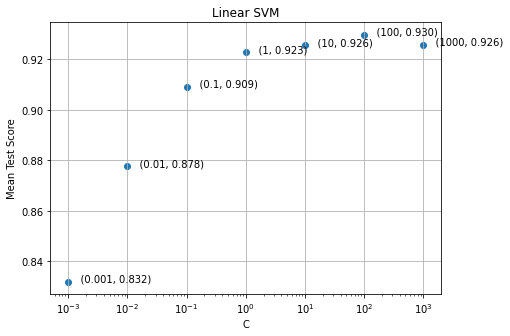

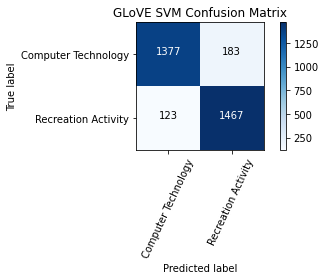

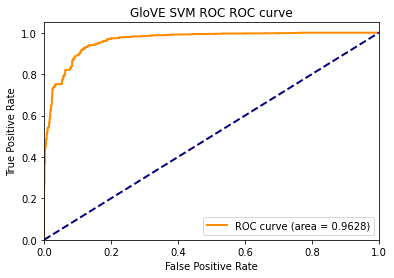

In [ ]:
# Part b: Binary classification with SVM 

# Find best params 
lsvc = LinearSVC(random_state=42,max_iter=10000) 
param_list = [0.001,0.01,0.1,1,10,100,1000]
params = {'C':param_list}
crof = GridSearchCV(lsvc,params,cv=5,scoring='accuracy') # Finding the best gamma using cross validation
crof.fit(XTrain_glove,y_train)

x = param_list
y = crof.cv_results_['mean_test_score']
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):                                       
    ax.annotate('    (%s, %.3f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C'); plt.ylabel('Mean Test Score'); plt.title("Linear SVM")
plt.grid()
ax.set_xscale('log')

ypred_cv = crof.best_estimator_.predict(XTest_glove)
bestsvm_gamma = crof.best_estimator_.C

print("Grid search results for SVM: ", crof.cv_results_)
print("Best estimator for SVM: ", crof.best_estimator_)
print("Best parameters for SVM: ", crof.best_params_)
print("Best score for SVM: ", crof.best_score_)
print("Best Gamma for SVM: ", bestsvm_gamma)
classifier_metrics(y_test,ypred_cv,name="Best Gamma SVM")

# Best Gamma confusion matrix
cv_confm = confusion_matrix(y_test,ypred_cv) 
plt.figure(); plotconfusion_matrix(cv_confm, classes=classnames, title='GLoVE SVM Confusion Matrix')

plotroc_curve(y_test,crof.best_estimator_.decision_function(XTest_glove),name="GloVE SVM ROC") # Best Gamma SVM ROC curve 

### Question 10: GLoVE results analysis part 1 

Plot the relationship between the dimension of the pre-trained GLoVE embedding
and the resulting accuracy of the model in the classification task.

Dim of GLoVE: 50, Accuracy: 0.8603174603174604
Dim of GLoVE: 100, Accuracy: 0.8831746031746032
Dim of GLoVE: 200, Accuracy: 0.9107936507936508
Dim of GLoVE: 300, Accuracy: 0.9028571428571428


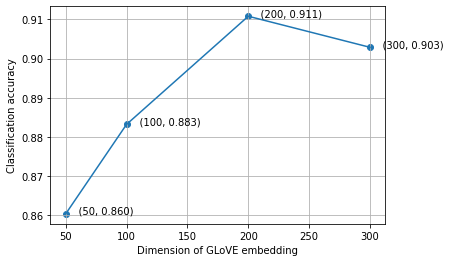

In [ ]:
dims_of_glove = [50,100,200,300]
acc_scores = []

for dim in dims_of_glove: 
  # Load GLoVE embeddings
  embeddings_dict = load_glove(dim=dim)
  
  # Get GLoVE representations of input data
  XTrain_glove = features_from_glove(traindataset.data, embeddings_dict, dim)
  XTest_glove = features_from_glove(testdataset.data, embeddings_dict, dim)
  
  # Perform classification 
  SVM = LinearSVC(C=bestsvm_gamma,random_state=42,max_iter=10000)
  y_pred = SVM.fit(XTrain_glove,y_train).predict(XTest_glove) # predicting labels for soft margin SVM
  acc_scores.append(accuracy_score(y_test,y_pred))

  print(f'Dim of GLoVE: {dim}, Accuracy: {accuracy_score(y_test,y_pred)}')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(dims_of_glove, acc_scores)
plt.scatter(dims_of_glove, acc_scores)
for xy in zip(dims_of_glove, acc_scores):                                       
    ax.annotate('    (%s, %.3f)' % xy, xy=xy, textcoords='data')
plt.xlabel('Dimension of GLoVE embedding'); plt.ylabel('Classification accuracy'); 
plt.grid()

### Question 11: GLoVE results analysis part 2 

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:253: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib/python3.6/dist-packages/umap/spectral.py:253: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


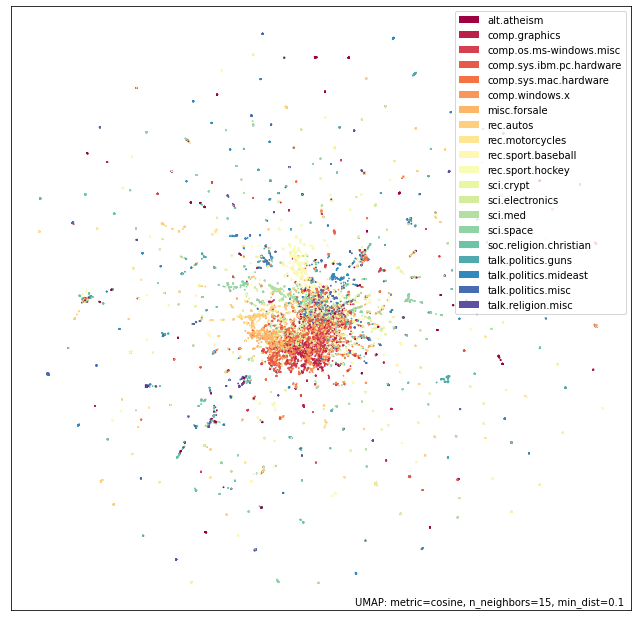

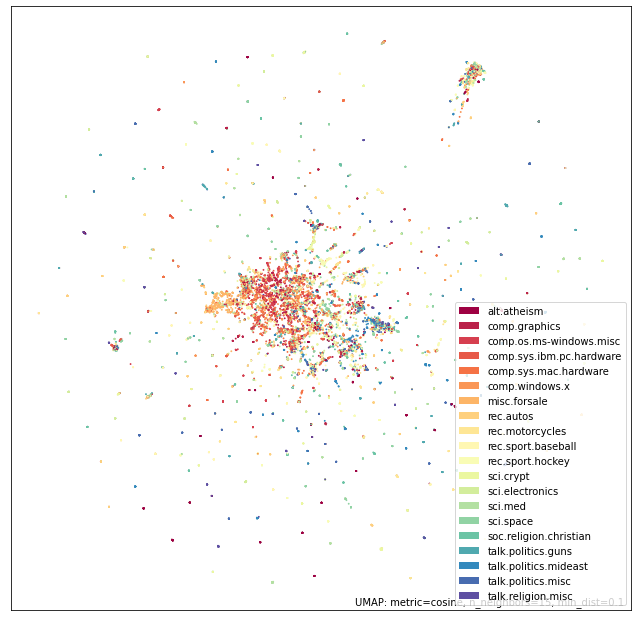

In [ ]:
# Adapated code from: https://umap-learn.readthedocs.io/en/latest/document_embedding.html

import pandas as pd
import umap
import umap.plot

# Get entire dataset
entire_dataset = fetch_20newsgroups(subset='all',
                             shuffle=True, random_state=42)
category_labels = [entire_dataset.target_names[x] for x in entire_dataset.target]
hover_df = pd.DataFrame(category_labels, columns=['category'])

 # Get GLoVE and random embeddings
dim_of_glove = 300
embeddings_dict = load_glove(dim=dim_of_glove)

random_embeddings_dict = {}
for word in embeddings_dict.keys(): 
  random_vec = np.random.normal(size=(dim_of_glove)) # Generate normalized random vectors 
  random_embeddings_dict[word] = random_vec / np.sqrt(np.sum(np.square(random_vec)))  

# Get embeddings representation of wrod docs
word_doc_matrix_glove = features_from_glove(entire_dataset.data, embeddings_dict, dim_of_glove)
word_doc_matrix_random = features_from_glove(entire_dataset.data, random_embeddings_dict, dim_of_glove)

# Dimensionality reduction for visualization
embedding_glove = umap.UMAP(n_components=2, metric='cosine').fit(word_doc_matrix_glove)
embedding_random = umap.UMAP(n_components=2, metric='cosine').fit(word_doc_matrix_random)

# Plot
f_glove = umap.plot.points(embedding_glove, labels=hover_df['category'])
f_random = umap.plot.points(embedding_random, labels=hover_df['category'])

## Multiclass classification

### Question 12: Multiclassification 

*   Naive Bayes
*   One vs One SVM
* One vs All SVM



In [ ]:
# setup multiclassification data
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']

traindataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42)# getting training data
traindataset = lemmatize_dataset(traindataset) # lemmatize 
y_train = traindataset.target

testdataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42) # getting test data
testdataset = lemmatize_dataset(testdataset) # lemmatize
y_test = testdataset.target

# TF-IDF feature extraction 
tfi_vect = TfidfVectorizer(stop_words='english',min_df=3)
XTrain_tfi = tfi_vect.fit_transform(traindataset.data) # making the tfidf train matrix
XTest_tfi = tfi_vect.transform(testdataset.data) # transforming the test data into the tfidf test matrix

# Dimensionality reduction 
lsi = TruncatedSVD(n_components=50, random_state=42)
XTrain_lsi = lsi.fit_transform(XTrain_tfi) # performing LSI on the tfidf train matrix
XTest_lsi = lsi.transform(XTest_tfi) # performing LSI on the tfidf test matrix

print(f'XTrain_lsi: {XTrain_lsi.shape}, y_train: {y_train.shape}')
print(f'XTest_lsi: {XTest_lsi.shape}, y_test: {y_test.shape}')

XTrain_lsi: (2352, 50), y_train: (2352,)
XTest_lsi: (1565, 50), y_test: (1565,)


Classification Report for Gaussian Naive Bayes:
                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.63      0.61      0.62       392
   comp.sys.mac.hardware       0.69      0.41      0.51       385
            misc.forsale       0.56      0.80      0.66       390
  soc.religion.christian       0.96      0.98      0.97       398

                accuracy                           0.70      1565
               macro avg       0.71      0.70      0.69      1565
            weighted avg       0.71      0.70      0.69      1565

Overall testing accuracy: 0.7009584664536741


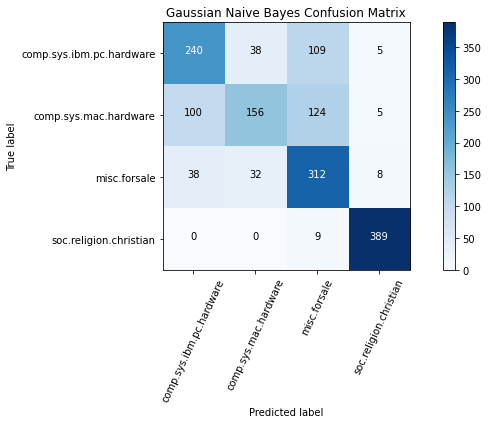

In [ ]:
from sklearn.metrics import classification_report

# Naive Bayes multiclassification 
clf = GaussianNB()
ypred_nb = clf.fit(XTrain_lsi, y_train).predict(XTest_lsi) # train and predict

print('Classification Report for Gaussian Naive Bayes:')
print(classification_report(y_test,ypred_nb, target_names = testdataset.target_names))

print(f'Overall testing accuracy: {accuracy_score(y_test,ypred_nb)}')

nb_confm = confusion_matrix(y_test,ypred_nb)
plt.figure(figsize=(10,6))
plotconfusion_matrix(nb_confm, classes=testdataset.target_names, title='Gaussian Naive Bayes Confusion Matrix')

Grid search results for SVM:  {'mean_fit_time': array([0.577633  , 0.56889777, 0.37583523, 0.20632534, 0.16957021,
       0.16667995, 0.16781549]), 'std_fit_time': array([0.00731145, 0.00327358, 0.00602222, 0.00264751, 0.00431509,
       0.00482051, 0.0043123 ]), 'mean_score_time': array([0.08697152, 0.08466597, 0.06514764, 0.04160395, 0.03500519,
       0.03320274, 0.0332963 ]), 'std_score_time': array([0.00233565, 0.00030602, 0.00043527, 0.00044605, 0.00094547,
       0.00082531, 0.00083793]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.25477707, 0.42250531, 0.86836518, 0.8895966 , 0.90658174,
       0.89808917, 0.89384289]), 'split1_test_score': array([0.25477707, 0.44585987, 0.86624204, 0.89596603, 0.88110403,
       

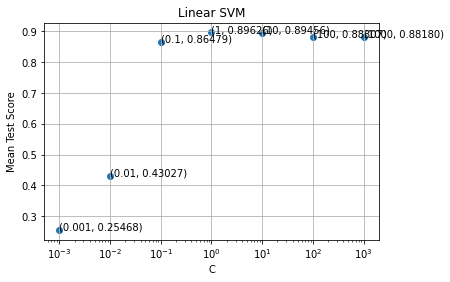

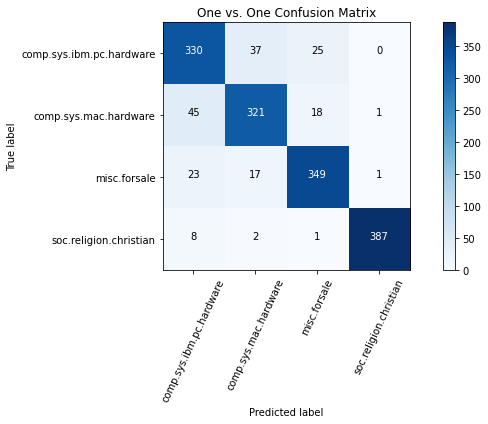

In [ ]:
# One vs. One -- SVC performs One vs. One
from sklearn.svm import SVC 

# Grid search params
params_list = [0.001,0.01,0.1,1,10,100,1000]
params = {'C':[0.001,0.01,0.1,1,10,100,1000]}

# initalize and train using grid search 
svc = SVC(random_state=42, max_iter=10000)
crof = GridSearchCV(svc,params,cv=5,scoring='accuracy') # Finding the best gamma using cross validation
crof.fit(XTrain_lsi,y_train)

# results of grid search
y = crof.cv_results_['mean_test_score']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):                                       
    ax.annotate('(%s, %.5f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title("Linear SVM")
plt.grid()
ax.set_xscale('log')

# predictions using best hyperparams
ypred_cv = crof.best_estimator_.predict(XTest_lsi)
bestsvm_gamma = crof.best_estimator_.C

print("Grid search results for SVM: ", crof.cv_results_)
print("Best estimator for SVM: ", crof.best_estimator_)
print("Best parameters for SVM: ", crof.best_params_)
print("Best score for SVM: ", crof.best_score_)
print("Best Gamma for SVM: ", bestsvm_gamma)

# Classification metrics 
print('Classification Report for One vs One SVM:')
print(classification_report(y_test,ypred_cv,target_names=testdataset.target_names))

print(f'Overall testing accuracy: {accuracy_score(y_test,ypred_cv)}')

cv_confm = confusion_matrix(y_test,ypred_cv) # Best Gamma SVM confusion matrix
plt.figure(figsize=(10,6))
plotconfusion_matrix(cv_confm, classes=testdataset.target_names, title='One vs. One Confusion Matrix')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Grid search results for SVM:  {'mean_fit_time': array([0.01653538, 0.01358171, 0.01904778, 0.03360825, 0.1557991 ,
       1.24133749, 3.69552479]), 'std_fit_time': array([0.00187076, 0.00015662, 0.00014747, 0.0004059 , 0.00577836,
       0.08852132, 0.06028301]), 'mean_score_time': array([0.00058575, 0.00055342, 0.00059872, 0.00062671, 0.0006124 ,
       0.00067544, 0.00059657]), 'std_score_time': array([4.25100795e-05, 2.53919257e-05, 2.23831243e-05, 3.36143479e-05,
       1.99444516e-05, 1.12605173e-04, 2.40764520e-05]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.83227176, 0.87261146, 0.88747346, 0.90021231, 0.9044586 ,
       0.89596603, 0.89808917]), 'split1_test_score': array([0.81528662, 0.87048832, 0.87685775, 0.8

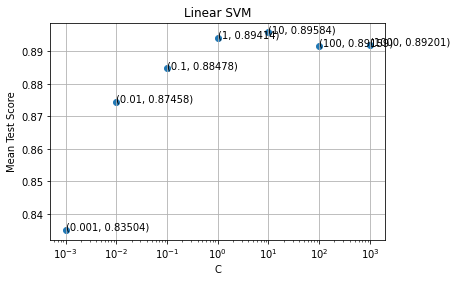

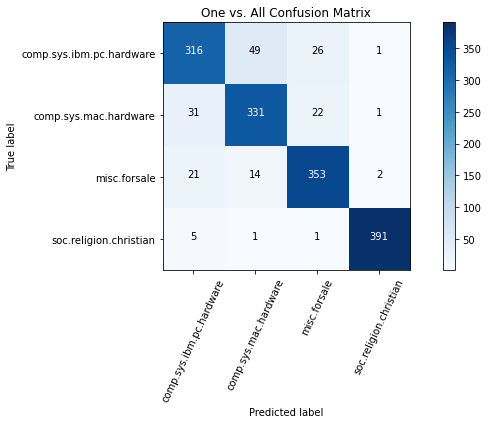

In [ ]:
# One vs. all -- LinearSVC performs One vs. All
from sklearn.svm import LinearSVC 

# Grid search params
params_list = [0.001,0.01,0.1,1,10,100,1000]
params = {'C':[0.001,0.01,0.1,1,10,100,1000]}

# initalize and train using grid search 
lsvc = LinearSVC(random_state=42,max_iter=10000) 
crof = GridSearchCV(lsvc,params,cv=5,scoring='accuracy') # Finding the best gamma using cross validation
crof.fit(XTrain_lsi,y_train)

# results of grid search
y = crof.cv_results_['mean_test_score']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):                                       
    ax.annotate('(%s, %.5f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title("Linear SVM")
plt.grid()
ax.set_xscale('log')

# predictions using best hyperparams
ypred_cv = crof.best_estimator_.predict(XTest_lsi)
bestsvm_gamma = crof.best_estimator_.C

print("Grid search results for SVM: ", crof.cv_results_)
print("Best estimator for SVM: ", crof.best_estimator_)
print("Best parameters for SVM: ", crof.best_params_)
print("Best score for SVM: ", crof.best_score_)
print("Best Gamma for SVM: ", bestsvm_gamma)

# Classification metrics 
print('Classification Report for One vs All SVM:')
print(classification_report(y_test,ypred_cv,target_names=testdataset.target_names))

print(f'Overall testing accuracy: {accuracy_score(y_test,ypred_cv)}')

cv_confm = confusion_matrix(y_test,ypred_cv) # Best Gamma SVM confusion matrix
plt.figure(figsize=(10,6))
plotconfusion_matrix(cv_confm, classes=testdataset.target_names, title='One vs. All Confusion Matrix')